# Imports

In [1]:
import os
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt
from torch.utils.data import TensorDataset, Dataset, DataLoader, random_split
from sklearn.model_selection import train_test_split
from collections import defaultdict

# Helper Functions

In [65]:
def get_peak_coordinates(matrix):
    matrix_2d = matrix.squeeze()
    idx = np.unravel_index(np.argmax(matrix_2d), matrix_2d.shape)
    return idx

def isolate_peak(matrix):
    mat = matrix.squeeze()
    clean = np.zeros_like(mat)
    peak_idx = np.unravel_index(np.argmax(mat), mat.shape)
    clean[peak_idx] = mat[peak_idx]
    return clean

def normalize_matrix(mat):
    return (mat - np.mean(mat)) / (np.std(mat) + 1e-5)

def compute_accuracy(loader, allow_adjacent=False):
    decoded_samples = []
    Y_targets = []

    with torch.no_grad():
        for X_batch, Y_batch in loader:
            X_batch = X_batch.to(device)
            output = model(X_batch).cpu().numpy()
            decoded_samples.extend(output)
            Y_targets.extend(Y_batch.numpy())

    decoded_samples = np.array(decoded_samples)
    Y_targets = np.array(Y_targets)

    correct = 0
    for i in range(len(Y_targets)):
        true_y, true_x = get_peak_coordinates(Y_targets[i])
        pred_y, pred_x = get_peak_coordinates(decoded_samples[i])
        if allow_adjacent:
            dist = np.sqrt((true_x - pred_x)**2 + (true_y - pred_y)**2)
            if dist <= 1.0:
                correct += 1
        else:
            if (true_x, true_y) == (pred_x, pred_y):
                correct += 1

    return correct / len(Y_targets)

# Load and Preprocess Training Data

In [ ]:
# Paths
dataset_dirs = [
    "/6x6/training_set_0",
    "/6x6/training_set_1",
    "/6x6/training_set_2",
    "/6x6/training_set_3",
    "/6x6/training_set_4",
    "/6x6/training_set_5"
]

no_touch_dir = "/no_touch_set"

# Load training data
X, Y_clean = [], []

for dataset_dir in dataset_dirs:
    for fname in sorted(os.listdir(dataset_dir)):
        if fname.endswith(".npy"):
            matrix = np.load(os.path.join(dataset_dir, fname)).astype("float32") / 4095.0
            x, y, _ = map(int, fname[:-4].split("_"))

            clean = np.zeros_like(matrix)
            clean[y, x] = matrix[y, x]

            X.append(normalize_matrix(matrix))
            Y_clean.append(normalize_matrix(clean))

# Load no-touch data
X_no_touch, Y_no_touch = [], []

for fname in sorted(os.listdir(no_touch_dir)):
    if fname.endswith(".npy"):
        matrix = np.load(os.path.join(no_touch_dir, fname)).astype("float32") / 4095.0
        clean = np.zeros_like(matrix)

        X_no_touch.append(normalize_matrix(matrix))
        Y_no_touch.append(normalize_matrix(clean))

# Stack all data, add channel dimension
X_total_np = np.stack(X + X_no_touch)[..., np.newaxis]  # shape: [N, 6, 6, 1]
Y_total_np = np.stack(Y_clean + Y_no_touch)[..., np.newaxis]

# Convert to PyTorch tensors: [N, 1, 6, 6]
X_total = torch.tensor(X_total_np, dtype=torch.float32).permute(0, 3, 1, 2)
Y_total = torch.tensor(Y_total_np, dtype=torch.float32).permute(0, 3, 1, 2)

#  Build and Train Denoising Autoencoder

In [ ]:
# Custom Loss Function: Focused Peak Loss
class FocusedPeakLoss(nn.Module):
    def __init__(self, peak_weight=2.0, suppress_weight=4.0, reinforce_weight=4.0):
        super(FocusedPeakLoss, self).__init__()
        self.peak_weight = peak_weight
        self.suppress_weight = suppress_weight
        self.reinforce_weight = reinforce_weight

    def forward(self, y_pred, y_true):
        epsilon = 1e-5
        peak_mask = (y_true.abs() > epsilon).float()
        suppress_mask = 1.0 - peak_mask

        peak_count = peak_mask.sum(dim=(1, 2, 3)).clamp(min=1.0)
        suppress_count = suppress_mask.sum(dim=(1, 2, 3)).clamp(min=1.0)

        peak_mse = ((peak_mask * (y_pred - y_true).pow(2)).sum(dim=(1, 2, 3)) / peak_count)
        suppress_loss = ((suppress_mask * y_pred.pow(2)).sum(dim=(1, 2, 3)) / suppress_count)
        reinforce = ((peak_mask * y_pred).sum(dim=(1, 2, 3)) / peak_count)

        total_loss = (
            self.peak_weight * peak_mse +
            self.suppress_weight * suppress_loss -
            self.reinforce_weight * reinforce
        )
        return total_loss.mean()

# CNN Autoencoder Model
class DenoisingAutoencoder(nn.Module):
    def __init__(self, dropout_rate=0.3):
        super(DenoisingAutoencoder, self).__init__()
        self.encoder = nn.Sequential(
            nn.Conv2d(1, 32, kernel_size=(4, 2), padding="same"),
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.Dropout2d(dropout_rate),
            nn.MaxPool2d((2, 2), padding=0),

            nn.Conv2d(32, 16, kernel_size=(4, 2), padding="same"),
            nn.BatchNorm2d(16),
            nn.ReLU(),
            nn.Dropout2d(dropout_rate),

            nn.Conv2d(16, 8, kernel_size=(4, 2), padding="same"),
            nn.BatchNorm2d(8),
            nn.ReLU(),
            nn.Dropout2d(dropout_rate),
        )
        self.decoder = nn.Sequential(
            nn.Upsample(scale_factor=(2, 2), mode='nearest'),
            nn.Conv2d(8, 8, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.Conv2d(8, 1, kernel_size=3, padding=1),
        )

    def forward(self, x):
        x = self.encoder(x)
        x = self.decoder(x)
        return x

# Prepare data loaders
dataset = TensorDataset(X_total, Y_total)
train_size = int(0.9 * len(dataset))
val_size = len(dataset) - train_size
train_set, val_set = random_split(dataset, [train_size, val_size], generator=torch.Generator().manual_seed(42))

train_loader = DataLoader(train_set, batch_size=4, shuffle=True, num_workers=0)
val_loader = DataLoader(val_set, batch_size=4, num_workers=0)

# Training Setup
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = DenoisingAutoencoder().to(device)
criterion = FocusedPeakLoss()
optimizer = optim.Adam(model.parameters(), lr=1e-4, weight_decay=1e-5)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode="min", factor=0.5, patience=200, min_lr=1e-6)

# Training Loop
best_val_loss = float("inf")
patience = 200
counter = 0

for epoch in range(1, 3001):
    model.train()
    train_loss = 0.0
    for X_batch, Y_batch in train_loader:
        X_batch, Y_batch = X_batch.to(device), Y_batch.to(device)
        optimizer.zero_grad()
        outputs = model(X_batch)
        loss = criterion(outputs, Y_batch)
        loss.backward()
        optimizer.step()
        train_loss += loss.item()

    train_loss /= len(train_loader)

    # Validation
    model.eval()
    val_loss = 0.0
    with torch.no_grad():
        for X_batch, Y_batch in val_loader:
            X_batch, Y_batch = X_batch.to(device), Y_batch.to(device)
            outputs = model(X_batch)
            loss = criterion(outputs, Y_batch)
            val_loss += loss.item()
    val_loss /= len(val_loader)
    scheduler.step(val_loss)

    print(f"Epoch {epoch} - Train Loss: {train_loss:.4f}, Val Loss: {val_loss:.4f}, Patience: {counter}/200")

    if val_loss < best_val_loss:
        best_epoch = epoch
        print(f"Model improved from {best_val_loss} to {val_loss}")
        best_val_loss = val_loss
        torch.save(model.state_dict(), "best_autoencoder.pth")
        counter = 0
        print("Model saved.")
    else:
        counter += 1
        if counter >= patience:
            print(f"Early stopping due to no model improvement. Retrieving checkpoint from epoch: {best_epoch}")
            break

Epoch 1 - Train Loss: 0.8389, Val Loss: 0.6212, Patience: 0/200
Model improved from inf to 0.621184253692627
Model saved.
Epoch 2 - Train Loss: 0.6737, Val Loss: 0.5736, Patience: 0/200
Model improved from 0.621184253692627 to 0.5735974905283555
Model saved.
Epoch 3 - Train Loss: 0.6341, Val Loss: 0.5306, Patience: 0/200
Model improved from 0.5735974905283555 to 0.5305721741655599
Model saved.
Epoch 4 - Train Loss: 0.6064, Val Loss: 0.5219, Patience: 0/200
Model improved from 0.5305721741655599 to 0.521944105366002
Model saved.
Epoch 5 - Train Loss: 0.5861, Val Loss: 0.5015, Patience: 0/200
Model improved from 0.521944105366002 to 0.5015170965505683
Model saved.
Epoch 6 - Train Loss: 0.5736, Val Loss: 0.4910, Patience: 0/200
Model improved from 0.5015170965505683 to 0.4910056716721991
Model saved.
Epoch 7 - Train Loss: 0.5613, Val Loss: 0.4743, Patience: 0/200
Model improved from 0.4910056716721991 to 0.47427955865859983
Model saved.
Epoch 8 - Train Loss: 0.5477, Val Loss: 0.4713, Pati

# Calculate Validation/Training Accuracy

In [ ]:
# Load model
model.load_state_dict(torch.load("best_autoencoder.pth"))
model.eval()

# Compute accuracy
val_acc_exact = compute_accuracy(val_loader, allow_adjacent=False)
val_acc_adj = compute_accuracy(val_loader, allow_adjacent=True)

train_acc_exact = compute_accuracy(train_loader, allow_adjacent=False)
train_acc_adj = compute_accuracy(train_loader, allow_adjacent=True)

# Print results
print(f"Validation Accuracy (Exact Match): {val_acc_exact:.2%}")
print(f"Validation Accuracy (Adjacent Allowed): {val_acc_adj:.2%}")
print(f"Training Accuracy (Exact Match): {train_acc_exact:.2%}")
print(f"Training Accuracy (Adjacent Allowed): {train_acc_adj:.2%}")

Validation Accuracy (Exact Match): 37.86%
Validation Accuracy (Adjacent Allowed): 49.02%
Training Accuracy (Exact Match): 44.57%
Training Accuracy (Adjacent Allowed): 55.99%


# Visualize Model Output

In [37]:
def print_matrices(i, X, Y_true, model):
    model.eval()
    with torch.no_grad():
        X_input = torch.tensor(X[i:i+1], dtype=torch.float32).to(device)
        pred = model(X_input).cpu().numpy()[0].squeeze()

    true = Y_true[i].squeeze()
    inp = X[i].squeeze()

    np.set_printoptions(precision=4, suppress=True)
    print(f"\nInput Matrix (#{i}):\n{inp}")
    print(f"\nGround Truth Matrix (#{i}):\n{true}")
    print(f"\nPredicted Matrix (#{i}):\n{pred}")

def plot_training_error_heatmap(X_train, Y_train, model, threshold=0.5):
    grid_size = (6, 6)
    total_counts = np.zeros(grid_size)
    incorrect_counts = np.zeros(grid_size)

    model.eval()
    predictions = []

    # Convert to PyTorch tensor and batch
    dataset = torch.utils.data.TensorDataset(torch.tensor(X_train).float())
    loader = torch.utils.data.DataLoader(dataset, batch_size=32, num_workers=2, shuffle=False)

    with torch.no_grad():
        for (X_batch,) in loader:
            X_batch = X_batch.to(device)
            batch_preds = model(X_batch).cpu().numpy()
            predictions.extend(batch_preds)

    predictions = np.array(predictions)

    for i in range(len(X_train)):
        pred = predictions[i].squeeze()
        true = Y_train[i].squeeze()

        if np.max(true) < 1e-3:
            continue  # Skip no-touch samples

        true_pos = np.unravel_index(np.argmax(true), grid_size)
        pred_pos = np.unravel_index(np.argmax(pred), grid_size)

        total_counts[true_pos] += 1
        dist = np.sqrt((true_pos[0] - pred_pos[0])**2 + (true_pos[1] - pred_pos[1])**2)
        if dist > threshold:
            incorrect_counts[true_pos] += 1

    error_rates = np.divide(
        incorrect_counts, total_counts,
        out=np.zeros_like(incorrect_counts), where=total_counts != 0
    )

    plt.figure(figsize=(6, 5))
    plt.imshow(error_rates, cmap="Reds", origin="lower")
    plt.colorbar(label="Training Error Rate")
    plt.title(f"Training Error Rate Heatmap (Threshold: {threshold} units)")
    plt.xlabel("X Coordinate")
    plt.ylabel("Y Coordinate")
    plt.xticks(np.arange(6))
    plt.yticks(np.arange(6))
    plt.grid(False)
    plt.show()

    return error_rates


Input Matrix (#0):
[[ 1.3338  1.3838  1.3838  1.3838  1.3838  2.3645]
 [ 0.8389  0.8389  0.8661  0.8389  0.6209  1.2385]
 [ 0.0352  0.0624  0.0125  0.0261  0.3394  1.0932]
 [-0.6913 -0.6868 -0.7413 -0.7095 -0.7685 -0.6141]
 [-0.9002 -0.8684 -0.8684 -0.9093 -0.9864 -0.7413]
 [-0.9774 -1.0863 -0.9774 -1.1953 -1.218  -1.1045]]

Ground Truth Matrix (#0):
[[-0.169  -0.169  -0.169  -0.169  -0.169  -0.169 ]
 [-0.169  -0.169  -0.169  -0.169  -0.169  -0.169 ]
 [-0.169  -0.169  -0.169  -0.169  -0.169  -0.169 ]
 [-0.169  -0.169  -0.169  -0.169  -0.169  -0.169 ]
 [-0.169  -0.169  -0.169  -0.169  -0.169  -0.169 ]
 [ 5.9155 -0.169  -0.169  -0.169  -0.169  -0.169 ]]

Predicted Matrix (#0):
[[ 0.5792  0.5792  0.5792  0.5792  0.5813  0.5794]
 [ 0.5792  0.5792  0.5792  0.5835  0.5856  0.5848]
 [ 0.5792  0.5792  0.5792  0.5801  0.585   0.5796]
 [ 0.5853  0.5793  0.5792  0.5792  0.5792  0.5792]
 [ 0.509   0.5428  0.5794  0.5792  0.5791  0.5841]
 [ 8.3695 -0.1858  0.6191  0.5792  0.5899  0.5951]]


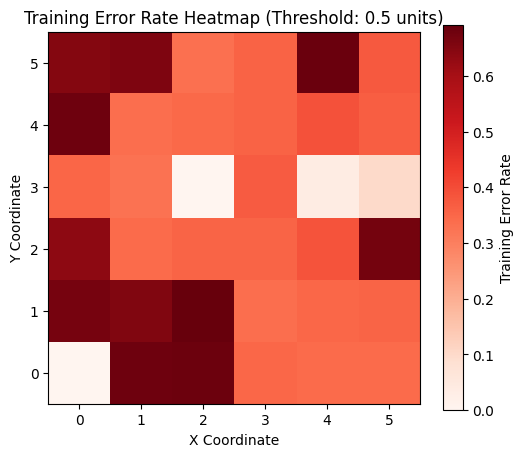

array([[0.    , 0.6786, 0.6814, 0.3486, 0.3426, 0.3423],
       [0.6667, 0.6542, 0.6909, 0.3364, 0.3482, 0.3558],
       [0.6355, 0.3426, 0.3558, 0.3558, 0.3868, 0.6696],
       [0.3509, 0.3274, 0.    , 0.3714, 0.037 , 0.1009],
       [0.6796, 0.3364, 0.3458, 0.3585, 0.39  , 0.3645],
       [0.6481, 0.6571, 0.3303, 0.3578, 0.6842, 0.3772]])

In [38]:
# Convert train_set back to arrays for visualization
X_train = []
Y_train = []
for x, y in train_set:
    X_train.append(x.numpy())
    Y_train.append(y.numpy())

X_train = np.stack(X_train)
Y_train = np.stack(Y_train)

# Show prediction for a specific training sample
print_matrices(0, X_train, Y_train, model)

# Plot heatmap of error rates on training data
plot_training_error_heatmap(X_train, Y_train, model, threshold=0.5)

# Plot Validation Predictions

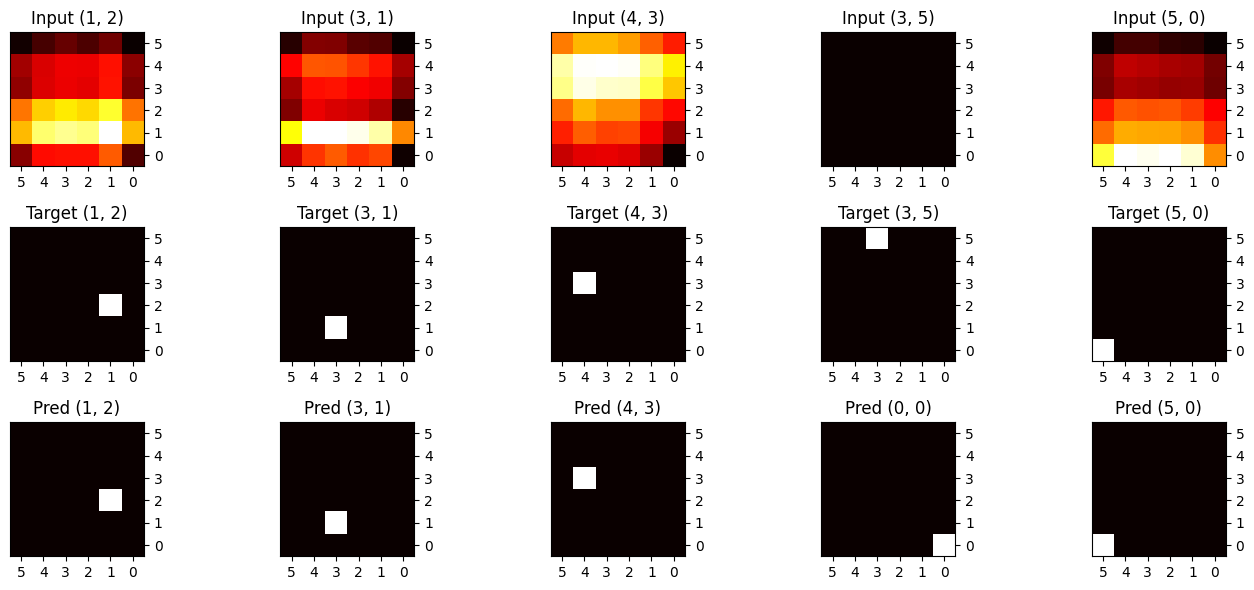

In [39]:
# Convert val_set to NumPy arrays
X_val = []
Y_val = []
for x, y in val_set:
    X_val.append(x.numpy())
    Y_val.append(y.numpy())

X_val = np.stack(X_val)
Y_val = np.stack(Y_val)

# Ensure X_val has shape (N, 6, 6, 1) for consistent display
if X_val.ndim == 4 and X_val.shape[1] == 1:
    X_val = np.transpose(X_val, (0, 2, 3, 1))  # (N, 1, 6, 6) → (N, 6, 6, 1)

# Get predictions
model.eval()
with torch.no_grad():
    X_val_tensor = torch.tensor(X_val).permute(0, 3, 1, 2).float().to(device)  # (N, 6, 6, 1) → (N, 1, 6, 6)
    decoded_samples = model(X_val_tensor).cpu().numpy()  # (N, 1, 6, 6)

# Ensure predictions are (N, 6, 6)
decoded_samples = np.squeeze(decoded_samples, axis=1)

# Visualization
sample_indices = np.random.choice(len(Y_val), size=min(5, len(Y_val)), replace=False)
n = len(sample_indices)
plt.figure(figsize=(14, 6))

for j, i in enumerate(sample_indices):
    true_y, true_x = np.unravel_index(np.argmax(Y_val[i].squeeze()), (6, 6))
    pred_y, pred_x = get_peak_coordinates(decoded_samples[i])

    # Input
    ax1 = plt.subplot(3, n, j + 1)
    ax1.imshow(X_val[i].squeeze(), cmap="hot")
    ax1.set_title(f"Input ({true_x}, {true_y})")
    ax1.set_xticks(range(6))
    ax1.set_yticks(range(6))
    ax1.set_xticklabels(list(reversed(range(6))))
    ax1.set_yticklabels(list(reversed(range(6))))
    ax1.yaxis.tick_right()

    # Target
    ax2 = plt.subplot(3, n, j + 1 + n)
    ax2.imshow(np.fliplr(Y_val[i].squeeze()), cmap="hot", origin="lower")
    ax2.set_title(f"Target ({true_x}, {true_y})")
    ax2.set_xticks(range(6))
    ax2.set_yticks(range(6))
    ax2.set_xticklabels(list(reversed(range(6))))
    ax2.set_yticklabels(list(range(6)))
    ax2.yaxis.tick_right()

    # Prediction
    ax3 = plt.subplot(3, n, j + 1 + 2 * n)
    ax3.imshow(np.fliplr(isolate_peak(decoded_samples[i])), cmap="hot", origin="lower")
    ax3.set_title(f"Pred ({pred_x}, {pred_y})")
    ax3.set_xticks(range(6))
    ax3.set_yticks(range(6))
    ax3.set_xticklabels(list(reversed(range(6))))
    ax3.set_yticklabels(list(range(6)))
    ax3.yaxis.tick_right()

plt.tight_layout()
plt.show()

# Evaluate External Test Data

In [ ]:
# Load the Data
def load_external_test_set(test_dir):
    X_ext, Y_ext_clean = [], []
    for fname in sorted(os.listdir(test_dir)):
        if fname.endswith(".npy"):
            matrix = np.load(os.path.join(test_dir, fname)).astype("float32") / 4095.0
            x, y, _ = map(int, fname[:-4].split("_"))
            clean = np.zeros_like(matrix)
            clean[y, x] = matrix[y, x]

            X_ext.append(normalize_matrix(matrix))
            Y_ext_clean.append(normalize_matrix(clean))

    X_ext = np.array(X_ext)[..., np.newaxis]
    Y_ext_clean = np.array(Y_ext_clean)[..., np.newaxis]
    return X_ext, Y_ext_clean

# Plot Samples
def plot_external_predictions(X_ext, Y_ext_clean, decoded_ext, output_prefix):
    n = min(5, len(X_ext))
    indices = np.random.choice(len(X_ext), size=n, replace=False)

    plt.figure(figsize=(14, 6))
    for j, i in enumerate(indices):
        true_y, true_x = get_peak_coordinates(Y_ext_clean[i])
        pred_y, pred_x = get_peak_coordinates(decoded_ext[i])

        ax1 = plt.subplot(3, n, j + 1)
        ax1.imshow(X_ext[i].squeeze(), cmap="hot")
        ax1.set_title(f"Input ({true_x}, {true_y})")
        ax1.set_xticks(range(6)); ax1.set_yticks(range(6))
        ax1.set_xticklabels(list(reversed(range(6)))); ax1.set_yticklabels(list(reversed(range(6))))
        ax1.yaxis.tick_right()

        ax2 = plt.subplot(3, n, j + 1 + n)
        ax2.imshow(np.fliplr(Y_ext_clean[i].squeeze()), cmap="hot", origin="lower")
        ax2.set_title(f"Target ({true_x}, {true_y})")
        ax2.set_xticks(range(6)); ax2.set_yticks(range(6))
        ax2.set_xticklabels(list(reversed(range(6)))); ax2.set_yticklabels(list(range(6)))
        ax2.yaxis.tick_right()

        ax3 = plt.subplot(3, n, j + 1 + 2 * n)
        ax3.imshow(np.fliplr(isolate_peak(decoded_ext[i])), cmap="hot", origin="lower")
        ax3.set_title(f"Pred ({pred_x}, {pred_y})")
        ax3.set_xticks(range(6)); ax3.set_yticks(range(6))
        ax3.set_xticklabels(list(reversed(range(6)))); ax3.set_yticklabels(list(range(6)))
        ax3.yaxis.tick_right()
    plt.tight_layout()
    plt.show()

# Save PDF
def save_predictions_pdf(X_ext, Y_ext_clean, decoded_ext, filename):
    n = len(X_ext)
    plt.figure(figsize=(12, 3 * n))
    for i in range(n):
        true_y, true_x = get_peak_coordinates(Y_ext_clean[i])
        pred_y, pred_x = get_peak_coordinates(decoded_ext[i])

        ax1 = plt.subplot(n, 3, 3*i + 1)
        ax1.imshow(X_ext[i].squeeze(), cmap="hot")
        ax1.set_title(f"Input ({true_x}, {true_y})")
        ax1.set_xticks(range(6)); ax1.set_yticks(range(6))
        ax1.set_xticklabels(list(reversed(range(6)))); ax1.set_yticklabels(list(reversed(range(6))))
        ax1.yaxis.tick_right()

        ax2 = plt.subplot(n, 3, 3*i + 2)
        ax2.imshow(np.fliplr(Y_ext_clean[i].squeeze()), cmap="hot", origin="lower")
        ax2.set_title(f"Target ({true_x}, {true_y})")
        ax2.set_xticks(range(6)); ax2.set_yticks(range(6))
        ax2.set_xticklabels(list(reversed(range(6)))); ax2.set_yticklabels(list(range(6)))
        ax2.yaxis.tick_right()

        ax3 = plt.subplot(n, 3, 3*i + 3)
        ax3.imshow(np.fliplr(isolate_peak(decoded_ext[i])), cmap="hot", origin="lower")
        ax3.set_title(f"Pred ({pred_x}, {pred_y})")
        ax3.set_xticks(range(6)); ax3.set_yticks(range(6))
        ax3.set_xticklabels(list(reversed(range(6)))); ax3.set_yticklabels(list(range(6)))
        ax3.yaxis.tick_right()
    plt.tight_layout()
    plt.savefig(filename, format="pdf", dpi=300)
    plt.close()

# Compute Accuracy per Coordinate
def compute_and_print_accuracy(decoded_ext, Y_ext_clean, coord_counts, coord_correct):
    threshold = 0.5
    for i in range(len(Y_ext_clean)):
        true_y, true_x = get_peak_coordinates(Y_ext_clean[i])
        pred_y, pred_x = get_peak_coordinates(decoded_ext[i])
        coord = (true_x, true_y)
        coord_counts[coord] += 1
        if np.sqrt((true_x - pred_x)**2 + (true_y - pred_y)**2) <= threshold:
            coord_correct[coord] += 1

# Main Evaluation Function
def evaluate_test_set(model, test_dir, output_prefix, coord_counts, coord_correct, plot=True, pdf=True, coords=True):
    X_ext, Y_ext_clean = load_external_test_set(test_dir)
    model.eval()
    with torch.no_grad():
        decoded_ext = model(torch.from_numpy(X_ext).permute(0, 3, 1, 2).float().to(device)).cpu().numpy()

    # Exact-match accuracy
    correct_exact = sum(
        get_peak_coordinates(Y_ext_clean[i]) == get_peak_coordinates(decoded_ext[i])
        for i in range(len(Y_ext_clean))
    )
    exact_accuracy = correct_exact / len(Y_ext_clean)

    # Adjacent-match accuracy
    correct_adj = sum(
        np.sqrt((get_peak_coordinates(Y_ext_clean[i])[1] - get_peak_coordinates(decoded_ext[i])[1])**2 +
                (get_peak_coordinates(Y_ext_clean[i])[0] - get_peak_coordinates(decoded_ext[i])[0])**2) <= 1.0
        for i in range(len(Y_ext_clean))
    )
    adjacent_accuracy = correct_adj / len(Y_ext_clean)

    print(f"[{output_prefix}] External Accuracy (Exact): {exact_accuracy:.2%}")
    print(f"[{output_prefix}] External Accuracy (Adjacent Allowed): {adjacent_accuracy:.2%}")

    if plot:
        plot_external_predictions(X_ext, Y_ext_clean, decoded_ext, output_prefix)
    if pdf:
        save_predictions_pdf(X_ext, Y_ext_clean, decoded_ext, f"{output_prefix}_results.pdf")
    if coords:
        compute_and_print_accuracy(decoded_ext, Y_ext_clean, coord_counts, coord_correct)

In [64]:
# Evaluate Across All Test Sets
coord_counts = defaultdict(int)
coord_correct = defaultdict(int)

test_set_paths = ["testing_set_0", "testing_set_1", "testing_set_2"]
base_path = "/Users/alexahitov/Desktop/arduino/Pressure Pad"

for i, path in enumerate(test_set_paths):
    test_dir = os.path.join(base_path, path)
    prefix = f"External Set {i}"
    evaluate_test_set(model, test_dir, prefix, coord_counts, coord_correct, plot=False, pdf=False)

# Compute and print accuracy per coordinate
print("\nPer-Coordinate Accuracy:")
for coord in sorted(coord_counts.keys()):
    count = coord_counts[coord]
    correct = coord_correct[coord]
    accuracy = correct / count if count > 0 else 0.0
    print(f"  Point {coord}: {correct}/{count} correct ({accuracy:.2%})")

# Overall Accuracy
total_correct = sum(coord_correct.values())
total_samples = sum(coord_counts.values())
overall_accuracy = total_correct / total_samples if total_samples > 0 else 0.0
print(f"\nOverall External Accuracy: {overall_accuracy:.2%}")

[External Set 0] External Accuracy (Exact): 44.44%
[External Set 0] External Accuracy (Adjacent Allowed): 77.78%
[External Set 1] External Accuracy (Exact): 36.11%
[External Set 1] External Accuracy (Adjacent Allowed): 66.67%
[External Set 2] External Accuracy (Exact): 38.89%
[External Set 2] External Accuracy (Adjacent Allowed): 77.78%

Per-Coordinate Accuracy:
  Point (0, 0): 3/3 correct (100.00%)
  Point (0, 1): 3/3 correct (100.00%)
  Point (0, 2): 2/3 correct (66.67%)
  Point (0, 3): 2/3 correct (66.67%)
  Point (0, 4): 2/3 correct (66.67%)
  Point (0, 5): 2/3 correct (66.67%)
  Point (1, 0): 3/3 correct (100.00%)
  Point (1, 1): 1/3 correct (33.33%)
  Point (1, 2): 2/3 correct (66.67%)
  Point (1, 3): 2/3 correct (66.67%)
  Point (1, 4): 0/3 correct (0.00%)
  Point (1, 5): 3/3 correct (100.00%)
  Point (2, 0): 0/3 correct (0.00%)
  Point (2, 1): 0/3 correct (0.00%)
  Point (2, 2): 3/3 correct (100.00%)
  Point (2, 3): 1/3 correct (33.33%)
  Point (2, 4): 0/3 correct (0.00%)
  Poi